In [1]:
import sys
import os
import pandas as pd

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

from utils.common import card_owner_age, expiry_days, activity_level

In [3]:
def clean_data(df):
    df = df.dropna()
    df = df[~df.duplicated()]
    return df

In [4]:
def data_ingestion():
    url = "https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data"
    credit_cards_df = clean_data(pd.read_parquet(url + "/credit_cards.parquet"))
    trans_df = clean_data(pd.read_parquet(url + "/transactions.parquet"))
    profiles_df = clean_data(pd.read_parquet(url + "/profiles.parquet"))

    return credit_cards_df, trans_df, profiles_df

In [5]:
credit_df, trans_df, profiles_df = data_ingestion()

In [6]:
can_df = card_owner_age(trans_df=trans_df, user_df=profiles_df)

In [7]:
can_df = expiry_days(trans_df=can_df, credit_cards_df=credit_df)

In [9]:
import yaml


config_path = '../../configuration.yaml'


with open(config_path, 'r') as file:
    config = yaml.safe_load(file)


activity_level_lag = config['activity_level_lag']

In [10]:
can_df = activity_level(trans_df=can_df, lag=activity_level_lag)

/home/chikwado/Desktop/Werkstatt/SafeSwipe/utils/common.py:68: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trans_df[["longitude", "latitude"]] = trans_df[["longitude", "latitude"]].applymap(radians)
/home/chikwado/Desktop/Werkstatt/SafeSwipe/utils/common.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_df.datetime = trans_df.datetime.map(lambda x: date_to_timestamp(x))


In [11]:
can_df.columns

Index(['tid', 'datetime', 'cc_num', 'category', 'amount', 'city', 'country',
       'age_of_user', 'days_to_card_expiration', 'loc_delta_t_minus_1',
       'time_delta_t_minus_1', 'fraud_label'],
      dtype='object')

In [12]:
can_df.dtypes

tid                         object
datetime                     int64
cc_num                       int64
category                    object
amount                     float64
city                        object
country                     object
age_of_user                  int32
days_to_card_expiration      int64
loc_delta_t_minus_1        float64
time_delta_t_minus_1       float64
fraud_label                  int64
dtype: object

In [13]:
num_features = can_df.columns[(can_df.dtypes == 'int64') | (can_df.dtypes == 'float64') | (can_df.dtypes == 'float32') | (can_df.dtypes == 'int32')  ].tolist()

In [14]:
num_features

['datetime',
 'cc_num',
 'amount',
 'age_of_user',
 'days_to_card_expiration',
 'loc_delta_t_minus_1',
 'time_delta_t_minus_1',
 'fraud_label']

In [15]:
can_df = can_df[["amount","age_of_user","days_to_card_expiration","loc_delta_t_minus_1","time_delta_t_minus_1","fraud_label"]]

In [16]:
can_df.head(5)

,amount,age_of_user,days_to_card_expiration,loc_delta_t_minus_1,time_delta_t_minus_1,fraud_label
0,62.95,34,479,0.221947,1.361921,0
1,85.45,34,478,0.103615,1.050301,0
2,21.63,34,477,0.167885,3.326192,0
3,54.71,34,476,0.263511,1.709850,0
4,59.22,34,474,0.573918,2.961331,0


In [17]:
can_df.fraud_label.value_counts()

fraud_label
0    105865
1       155
Name: count, dtype: int64

Modeling

In [21]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

In [26]:
features = ['amount', 'age_of_user', 'days_to_card_expiration', 'loc_delta_t_minus_1', 'time_delta_t_minus_1']

model = IsolationForest(contamination=0.0015, random_state=42)
model.fit(can_df[features])


IsolationForest(contamination=0.0015, random_state=42)

In [27]:
can_df['Anomaly'] = model.predict(can_df[features])
can_df['Anomaly'] = can_df['Anomaly'].map({1: 0, -1: 1})

In [28]:
from sklearn.metrics import confusion_matrix,precision_score, recall_score, classification_report

Confusion Matrix:
[[105708    157]
 [   152      3]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105865
           1       0.02      0.02      0.02       155

    accuracy                           1.00    106020
   macro avg       0.51      0.51      0.51    106020
weighted avg       1.00      1.00      1.00    106020



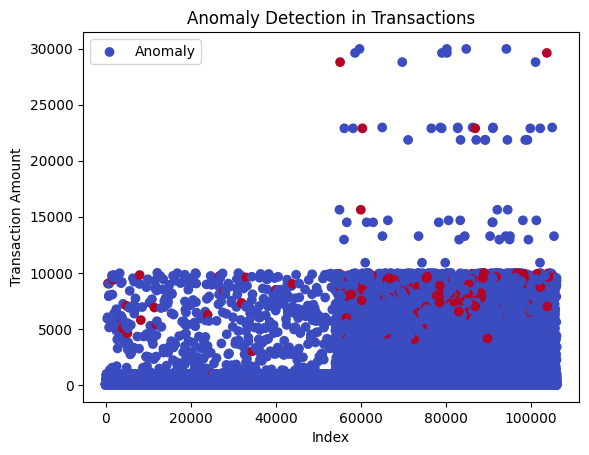

In [29]:
print("Confusion Matrix:")
print(confusion_matrix(can_df['fraud_label'], can_df['Anomaly']))

print("\nClassification Report:")
print(classification_report(can_df['fraud_label'], can_df['Anomaly']))

# Visualize the anomalies
plt.scatter(can_df.index, can_df['amount'], c=can_df['Anomaly'], cmap='coolwarm', label='Anomaly')
plt.title('Anomaly Detection in Transactions')
plt.xlabel('Index')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()